# Rift delineation from terrain steepness

This notebook employs the Random Forest algorithm, an ensemble machine learning method, to classify each point along an ICESat-2 track based on whether or not that point lies within a rift. The approach will be to compute the surface slope along each ICESat-2 track, and use the terrain steepness as the primary training dataset. We start by selecting the number of decision trees to include in our forest:

In [1]:
trees = 100 #choose the number of decision trees in the random forest

We then import all necessary packages and modules: 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from scipy.signal import resample, savgol_filter
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

/usr/local/lib64/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


and set paths as necessary.

In [3]:
training_data_path = '/data/fast1/rift-id/outputs' #where the training data are stored

## Step 1: Load and prepare data

We'll load elevation profiles for a collection of ICESat-2 tracks along with label arrays that classify each point as either "within a rift" (1) or "not within a rift" (0). These datasets will train the rift delineation model.

To rigorously test the model, we will exclude a selected rift from training and use it later for validation. Way may choose our validation rift from the following list:

In [4]:
training_data = pd.read_pickle(training_data_path + '/dml_all_bin_lr.pkl') #load the training data with rifted ice
rift_names = training_data['rift'] #the names of each rift
print('rift names:', set(rift_names))

rift names: {'F5', 'F6', 'F3a', 'F4'}


In [5]:
validation_rift = 'F3a' #this is the rift we'll exclude from training, for later testing. Or, write 'none'

With the validation rift selected, we now procure the appropriate data:

In [6]:
all_elevation_profiles = np.array(training_data['h_subset']) #surface elevations along each track
all_labels = np.array(training_data['bin_subset']) #binary labels at each point along tracks
x, y = training_data['x_subset'], training_data['y_subset'] #x and y coordinates along each track
distances = np.array(training_data['d_subset'])

mask = np.array(rift_names) != validation_rift  #Boolean mask for omitting the chosen rift name
elevation_profiles = [np.array(all_elevation_profiles[i]) for i in np.where(mask)[0]] #select relevant tracks
labels = [np.array(all_labels[i]) for i in np.where(mask)[0]] #and labels

smoothing_window = 50 #10 corresponds to about a 200-meter window
smoothed_elevations = savgol_filter(elevation_profiles, window_length = smoothing_window, polyorder = 2)
Δh_Δx = np.array([
    np.diff(smoothed_elevations[i]) / np.diff(distances[i])  #compute spatial derivative, dh/dx
    for i in range(len(smoothed_elevations))
])

### Modify the data 

In the loaded data, all training tracks have the rift positioned at the track center, and all tracks used as input have exactly the same length. However, this does not reflect real-world conditions, where (a) rifts may appear at arbitrary locations or not at all, and (b) ICESat-2 tracks may be cropped to different lengths, depending on how data are selected. 

To improve the model's ability to detect rifts at any position along a track of any length, we will modify the training data. Each track will be cropped to start and end at randomly-selected indices, so that (a) rifts will be randomly-placed, or may not appear at all, and (b) tracks will have different spatial lengths. (Because Random Forest requires training data vectors to have the same array length, this requires resampling the cropped tracks back to their original number of points).

In [7]:
Δh_Δx_cropped = []
labels_cropped = []

n = len(Δh_Δx[0])

for i in range(len(elevation_profiles)):
    for j in range(1000): #in fact, why not do this many times just to increase the training sample?
        start_index = np.random.randint(n - 1) #start anywhere less than n
        end_index = np.random.randint(start_index + 1, high = n) #end anywhere between start_index and n
        
        temp = Δh_Δx[i][start_index:end_index] #slice the track
        temp = resample(temp, n) #resample it to n points
        Δh_Δx_cropped.append(np.array(temp))
        
        temp = labels[i][start_index:end_index] #slice
        temp = resample(temp, n) #resample
        labels_cropped.append(np.rint(np.array(temp))) #np.rint to ensure we don't end up with nonbinary labels     

We should also ensure that we have a good balance of rifted vs. non-rifted training tracks:

In [8]:
count = sum(1 in entry for entry in labels_cropped)
print(f'{count/len(labels_cropped)*100:.2f}% of cropped tracks contain rifts')

49.49% of cropped tracks contain rifts


## Step 2: Train the model

In [9]:
training_data = {
    'features': Δh_Δx_cropped,
    'labels': labels_cropped
}

X_train, X_test, Y_train, Y_test = train_test_split(training_data['features'], training_data['labels'], 
                                                    test_size = 0.2, random_state=0)
model = RandomForestClassifier(n_estimators = trees)
model.fit(X_train, Y_train)
score = model.score(X_test,Y_test)
print(f'model score: {100*score : 0.2f}%')

model score:  55.16%


## Step 3: Test the model

We test the model by selecting a named rift, identifying all ICESat-2 tracks that contain it, and attempting to reproduce its classification. This comes in three steps. 

### (3a) Prepare testing data

This involves not just identifying tracks which contain the chosen rift, but also ensuring the data are modified to match the format used to train the model. This means smoothing the elevation profiles, computing spatial derivatives to obtain surface slope, and resampling all datasets to the correct size.

In [10]:
if validation_rift not in set(rift_names): #if we never omitted a rift in the training dataset:
    validation_rift = 'F3a' #we'll just look at this one (it's the biggest)

mask = np.array(rift_names) == validation_rift #boolean mask for matching the chosen rift name

test_labels = [np.array(all_labels[i]) for i in np.where(mask)[0]] #boolean labels from relevant tracks
test_labels = [np.rint(resample(entry, n)) for entry in test_labels] #ensure appropriate size

x_subset = [np.array(x[i]) for i in np.where(mask)[0]] #x-coords
x_subset = [resample(entry, n) for entry in x_subset] #resize
y_subset = [np.array(y[i]) for i in np.where(mask)[0]] #y-coords
y_subset = [resample(entry, n) for entry in y_subset] #resize

test_tracks = [np.array(all_elevation_profiles[i]) for i in np.where(mask)[0]] #select relevant tracks
test_tracks = savgol_filter(test_tracks, window_length = smoothing_window, polyorder=2) #smooth
test_distances = [np.array(distances[i]) for i in np.where(mask)[0]] #along-track distances

Δh_Δx_test = np.array([
    np.diff(test_tracks[i]) / np.diff(test_distances[i])  #compute dh/dx
    for i in range(len(test_tracks))
])
Δh_Δx_test = [resample(entry, n) for entry in Δh_Δx_test] #resize

### (3b) Obtain model predictions

In [11]:
output_labels = model.predict(Δh_Δx_test) #get model predictions

### (3c) Plot

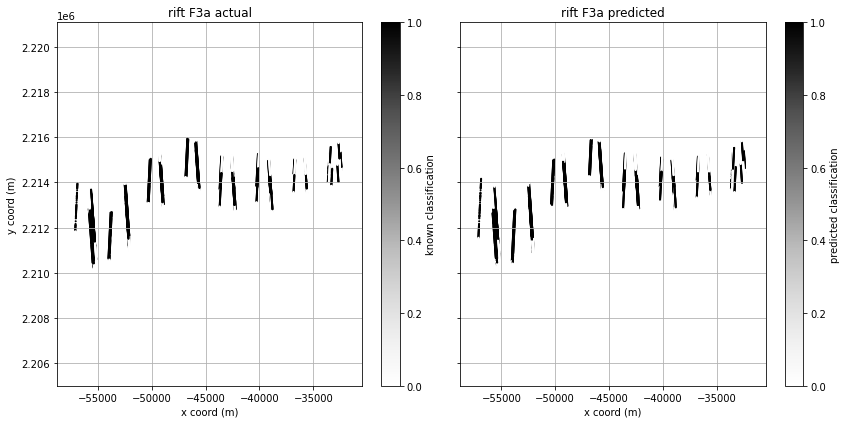

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharex=True, sharey=True) #and plot

#first subplot: known classification
sc1 = axes[0].scatter(x_subset, y_subset, s=1, c=test_labels, cmap='Greys')
cbar1 = fig.colorbar(sc1, ax=axes[0])
cbar1.set_label('known classification')
axes[0].set_xlabel('x coord (m)')
axes[0].set_ylabel('y coord (m)')
axes[0].grid()
axes[0].set_title(f'rift {validation_rift} actual')

#second subplot: predicted classification
sc2 = axes[1].scatter(x_subset, y_subset, s=1, c=output_labels, cmap='Greys')
cbar2 = fig.colorbar(sc2, ax=axes[1])
cbar2.set_label('predicted classification')
axes[1].set_xlabel('x coord (m)')
axes[1].grid()
axes[1].set_title(f'rift {validation_rift} predicted')

plt.tight_layout()
plt.show()